In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\\diplom\\datasets\\malevis\\300x300\\train',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(300, 300),
    shuffle = True
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\\diplom\\datasets\\malevis\\300x300\\val',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(300, 300),
    shuffle = True,
)

val_batches = tf.data.experimental.cardinality(ds_val)
ds_test = ds_val.take(val_batches // 5)
ds_val = ds_val.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(ds_val))
print('Number of test batches: %d' % tf.data.experimental.cardinality(ds_test))

Found 8750 files belonging to 25 classes.
Found 3644 files belonging to 25 classes.
Number of validation batches: 92
Number of test batches: 22


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)

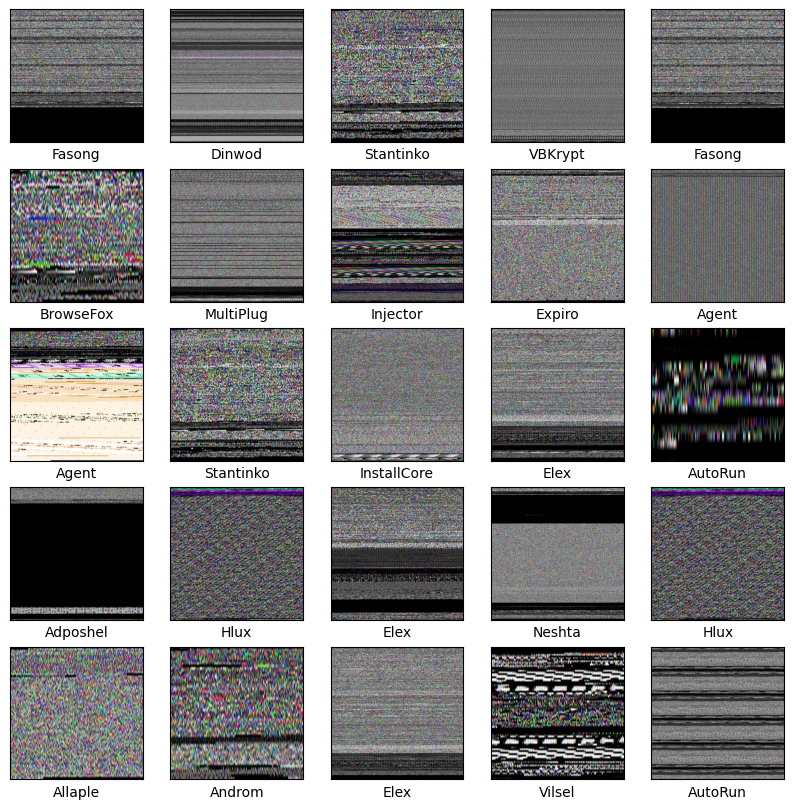

In [4]:
class_names = ["Adposhel", "Agent", "Allaple", "Amonetize", "Androm", "AutoRun", "BrowseFox", "Dinwod",
               "Elex", "Expiro", "Fasong", "HackKMS", "Hlux", "Injector", "InstallCore", "MultiPlug",
               "Neoreklami", "Neshta", "Regrun", "Sality", "Snarasite", "Stantinko", "Hilium", "VBKrypt", "Vilsel"]

for images, labels in ds_train.take(1):
    images = np.array(images.numpy(), np.uint8)
    plt.figure(figsize=(10,10))
    for i in range(25):
        c = np.argmax(labels[i])
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[c])
    plt.show()
    break

In [5]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(300, 300, 3),
                                               include_top=False,
                                               weights='imagenet')

In [7]:
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 1280)


In [8]:
base_model.trainable = False

In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [11]:
prediction_layer = tf.keras.layers.Dense(25)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 25)


In [12]:
inputs = tf.keras.Input(shape=(300, 300, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [15]:
len(model.trainable_variables)

2

In [16]:
# Number of epochs for model training (increase for the better accuracy)
initial_epochs = 10

loss0, accuracy0 = model.evaluate(ds_val)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

92/92 [==============================] - 132s 1s/step - loss: 3.5552 - accuracy: 0.0340
initial loss: 3.56
initial accuracy: 0.03


In [17]:
history = model.fit(ds_train,
                    epochs=initial_epochs,
                    validation_data=ds_val)

Epoch 1/10
274/274 [==============================] - 441s 2s/step - loss: 2.5160 - accuracy: 0.3449 - val_loss: 1.7343 - val_accuracy: 0.6612
Epoch 2/10
274/274 [==============================] - 404s 1s/step - loss: 1.5012 - accuracy: 0.6702 - val_loss: 1.2073 - val_accuracy: 0.7626
Epoch 3/10
274/274 [==============================] - 408s 1s/step - loss: 1.1297 - accuracy: 0.7537 - val_loss: 0.9605 - val_accuracy: 0.8003
Epoch 4/10
274/274 [==============================] - 420s 2s/step - loss: 0.9392 - accuracy: 0.7897 - val_loss: 0.8294 - val_accuracy: 0.8207
Epoch 5/10
274/274 [==============================] - 422s 2s/step - loss: 0.8156 - accuracy: 0.8120 - val_loss: 0.7360 - val_accuracy: 0.8388
Epoch 6/10
274/274 [==============================] - 436s 2s/step - loss: 0.7266 - accuracy: 0.8302 - val_loss: 0.6732 - val_accuracy: 0.8456
Epoch 7/10
274/274 [==============================] - 10799s 40s/step - loss: 0.6646 - accuracy: 0.8409 - val_loss: 0.6105 - val_accuracy: 0.8

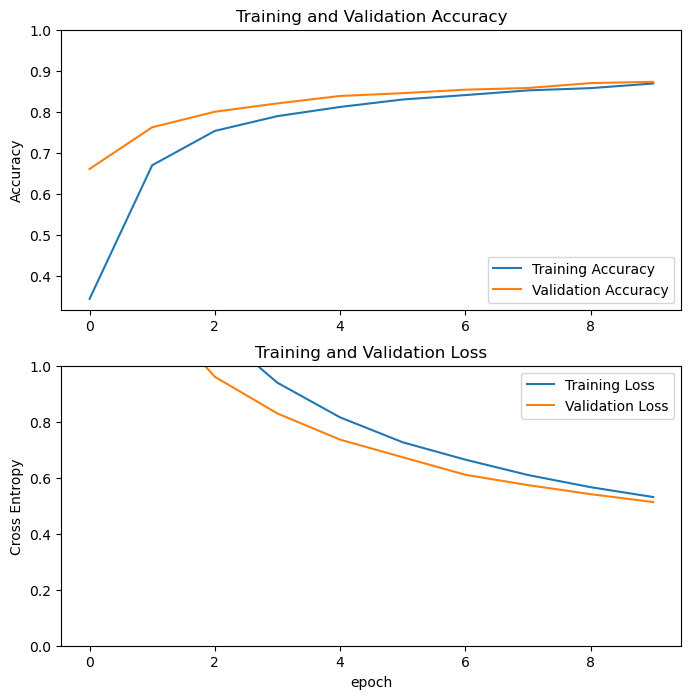

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
model.save("saloviho_DP")

INFO:tensorflow:Assets written to: saloviho_DP\assets


INFO:tensorflow:Assets written to: saloviho_DP\assets


In [25]:
base_model.trainable = True

In [26]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [27]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [28]:
# Number of epochs for fine-tuning (increase for better accuracy)
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(ds_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=ds_val)

Epoch 10/12
274/274 [==============================] - 515s 2s/step - loss: 0.3440 - accuracy: 0.8985 - val_loss: 0.3098 - val_accuracy: 0.9133
Epoch 11/12
274/274 [==============================] - 520s 2s/step - loss: 0.2616 - accuracy: 0.9266 - val_loss: 0.2675 - val_accuracy: 0.9282
Epoch 12/12
274/274 [==============================] - 562s 2s/step - loss: 0.2184 - accuracy: 0.9389 - val_loss: 0.2750 - val_accuracy: 0.9269


In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

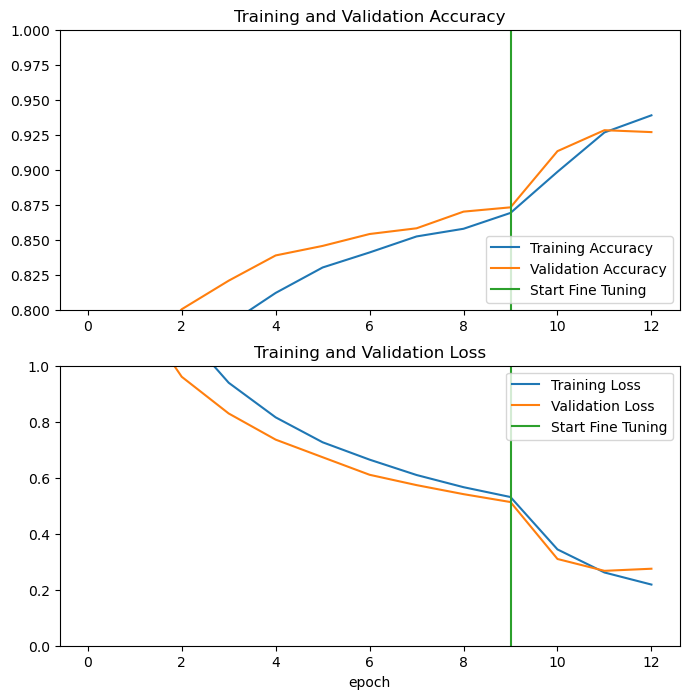

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [63]:
loss, accuracy = model.evaluate(ds_val)
print('Validation accuracy :', accuracy)

92/92 [==============================] - 108s 1s/step - loss: 0.2701 - accuracy: 0.9272
Validation accuracy : 0.9272108674049377


Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 

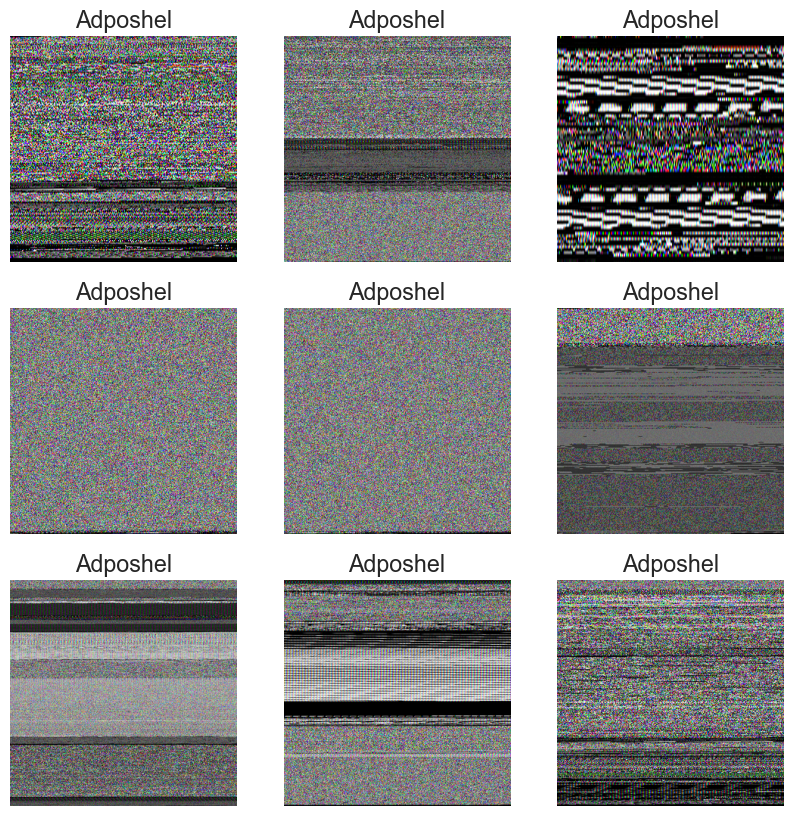

In [64]:
image_batch, label_batch = ds_test.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

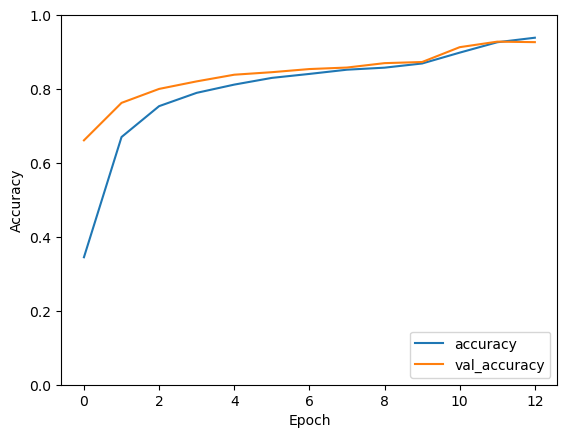

In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [34]:
test_loss, test_acc = model.evaluate(ds_test)
print(test_acc)

92/92 [==============================] - 121s 1s/step - loss: 0.2712 - accuracy: 0.9262
0.9261904954910278


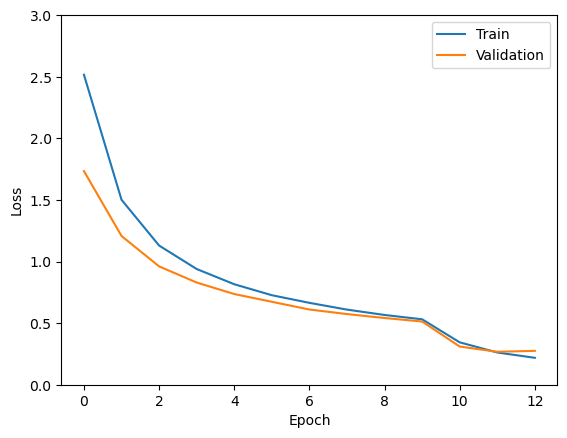

In [35]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.ylabel('Loss')

max_loss = max(history.history['loss'] + history.history['val_loss'])

plt.ylim([0, np.ceil(max_loss)])
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation']) 

In [41]:
def get_actual_predicted_labels(dataset):
    actual = None
    predicted = None
    for batch in dataset.as_numpy_iterator():
        image_batch, label_batch = batch
        predictions = model.predict_on_batch(image_batch)
        if predicted is None:
            predicted = np.argmax(predictions, axis=1)
            actual = np.argmax(label_batch, axis=1)
        else:
            predicted = np.concatenate((predicted, np.argmax(predictions, axis=1)))
            actual = np.concatenate((actual, np.argmax(label_batch, axis=1)))
    return actual, predicted

In [42]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True)
  sns.set(rc={'figure.figsize':(25, 25)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [43]:
actual, predicted = get_actual_predicted_labels(ds_train)

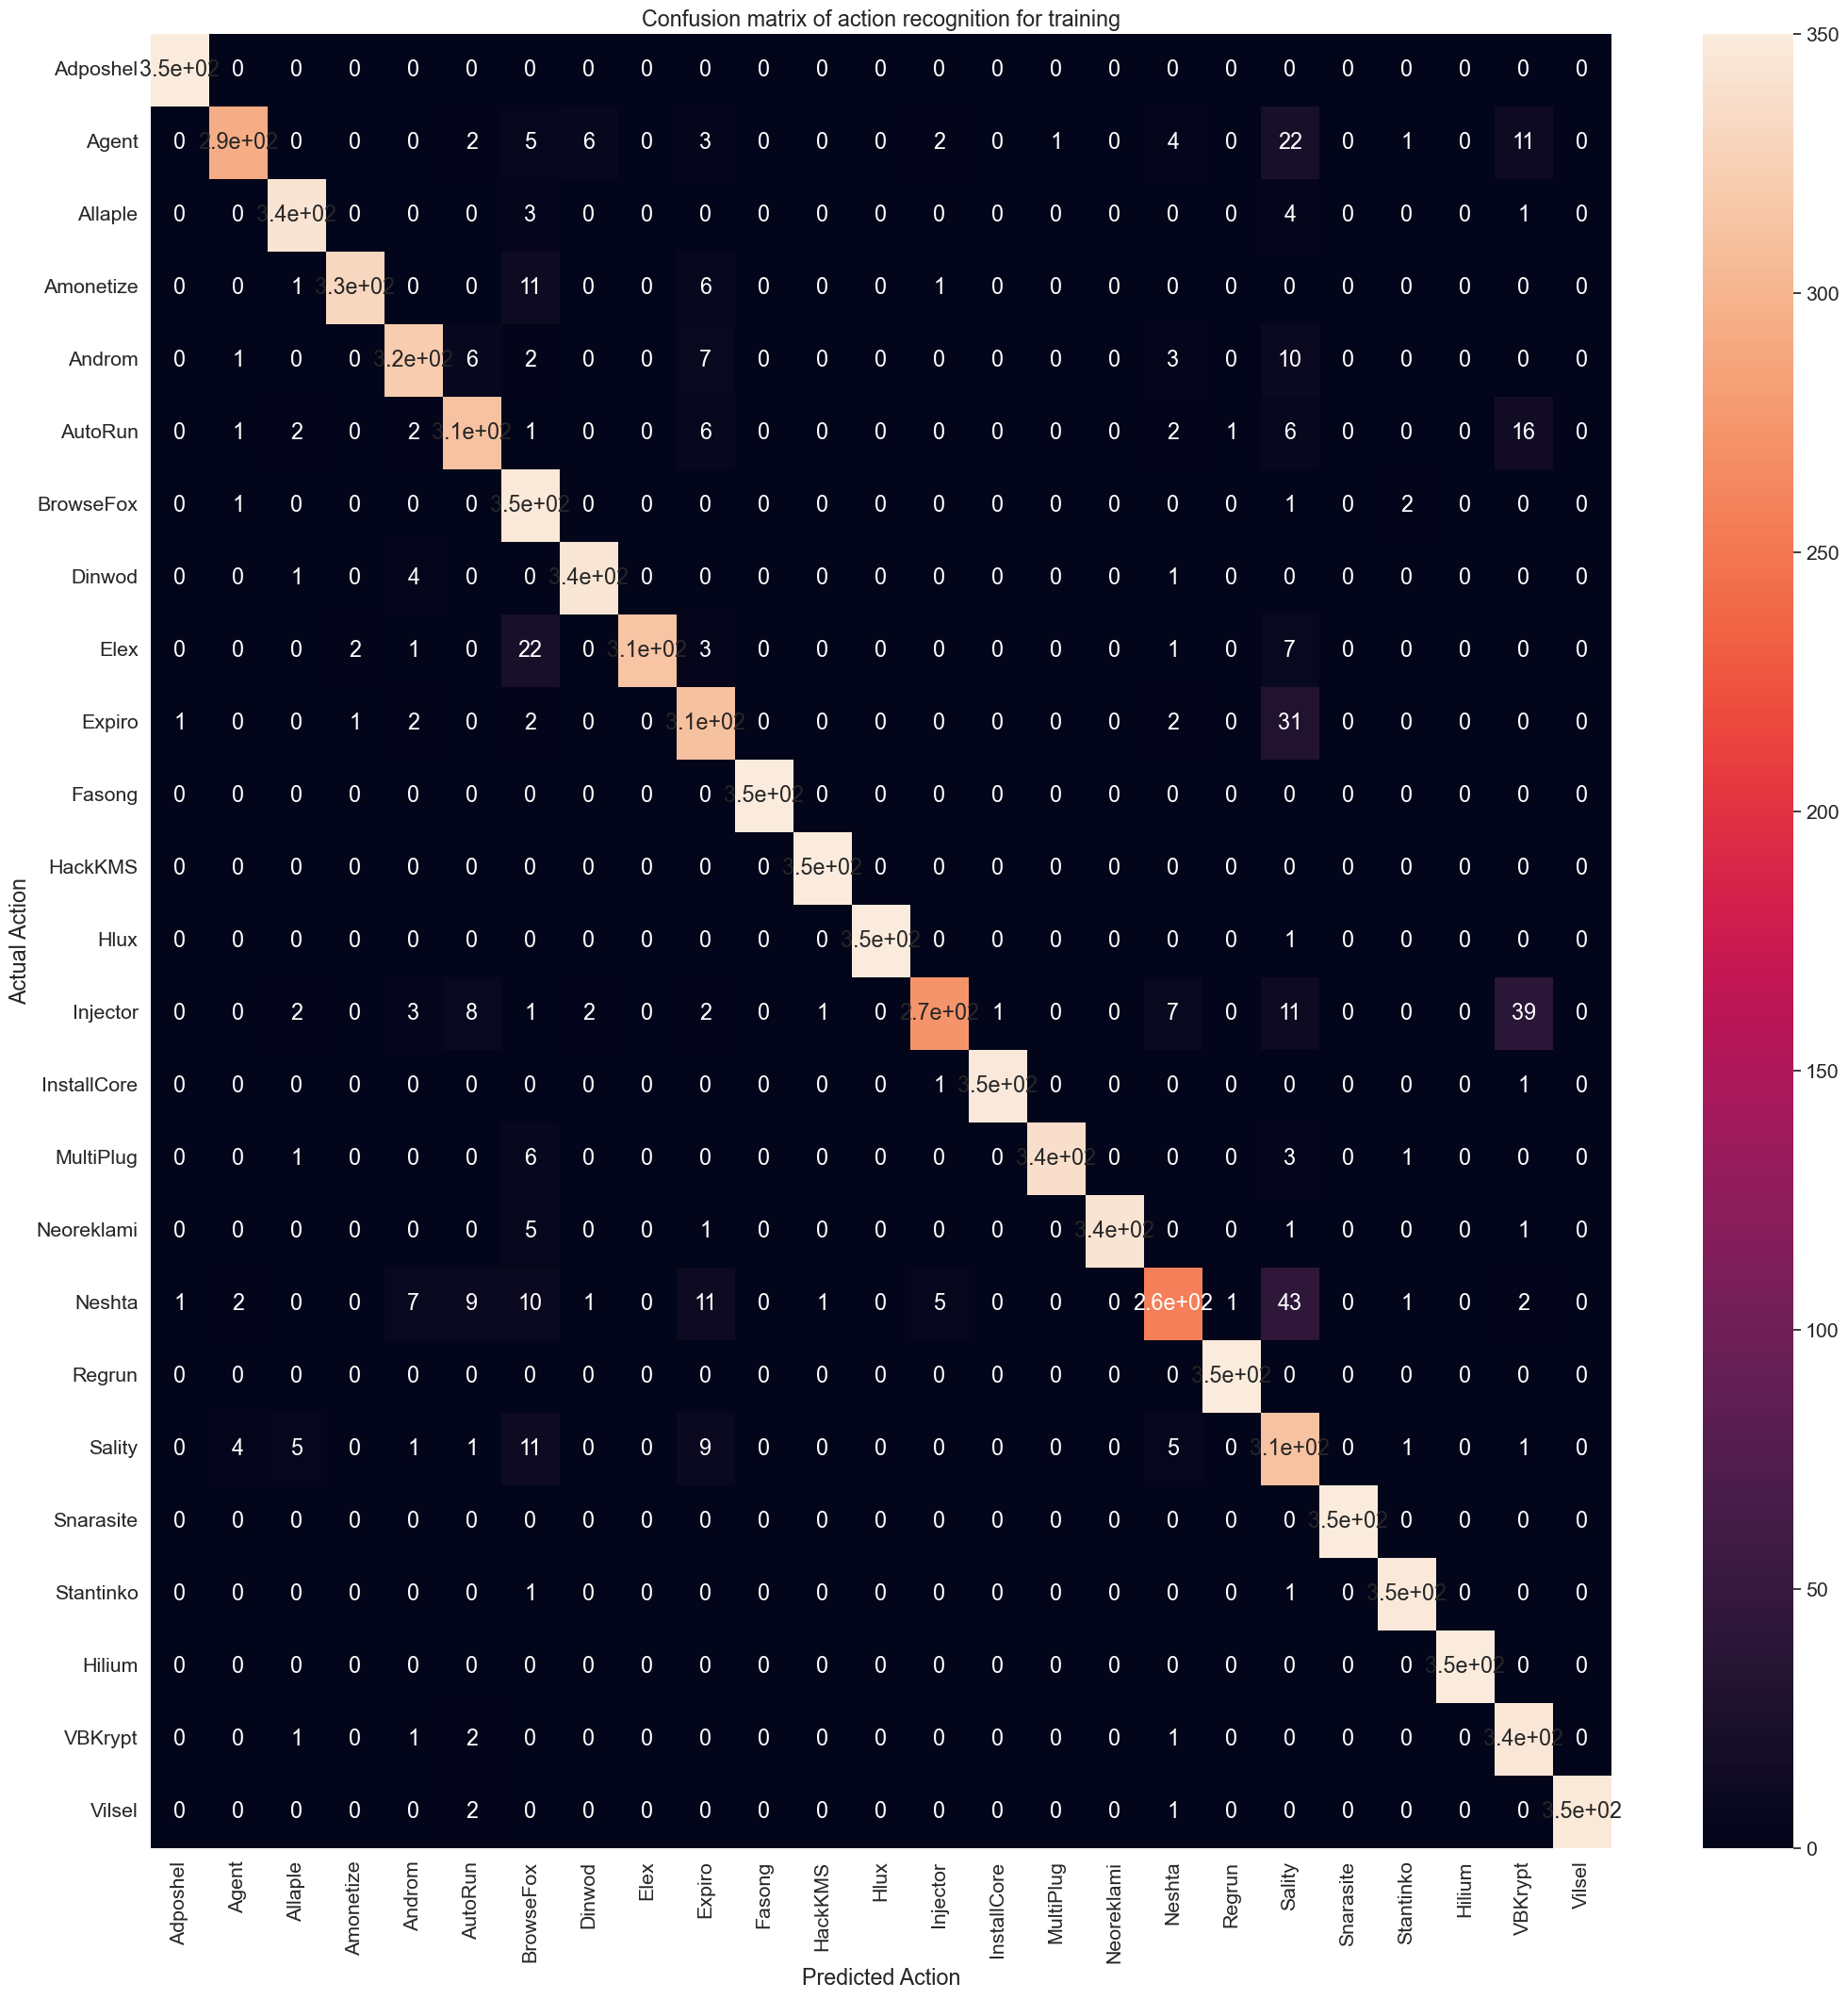

In [44]:
plot_confusion_matrix(actual, predicted, class_names, 'training')

In [47]:
actual, predicted = get_actual_predicted_labels(ds_val)

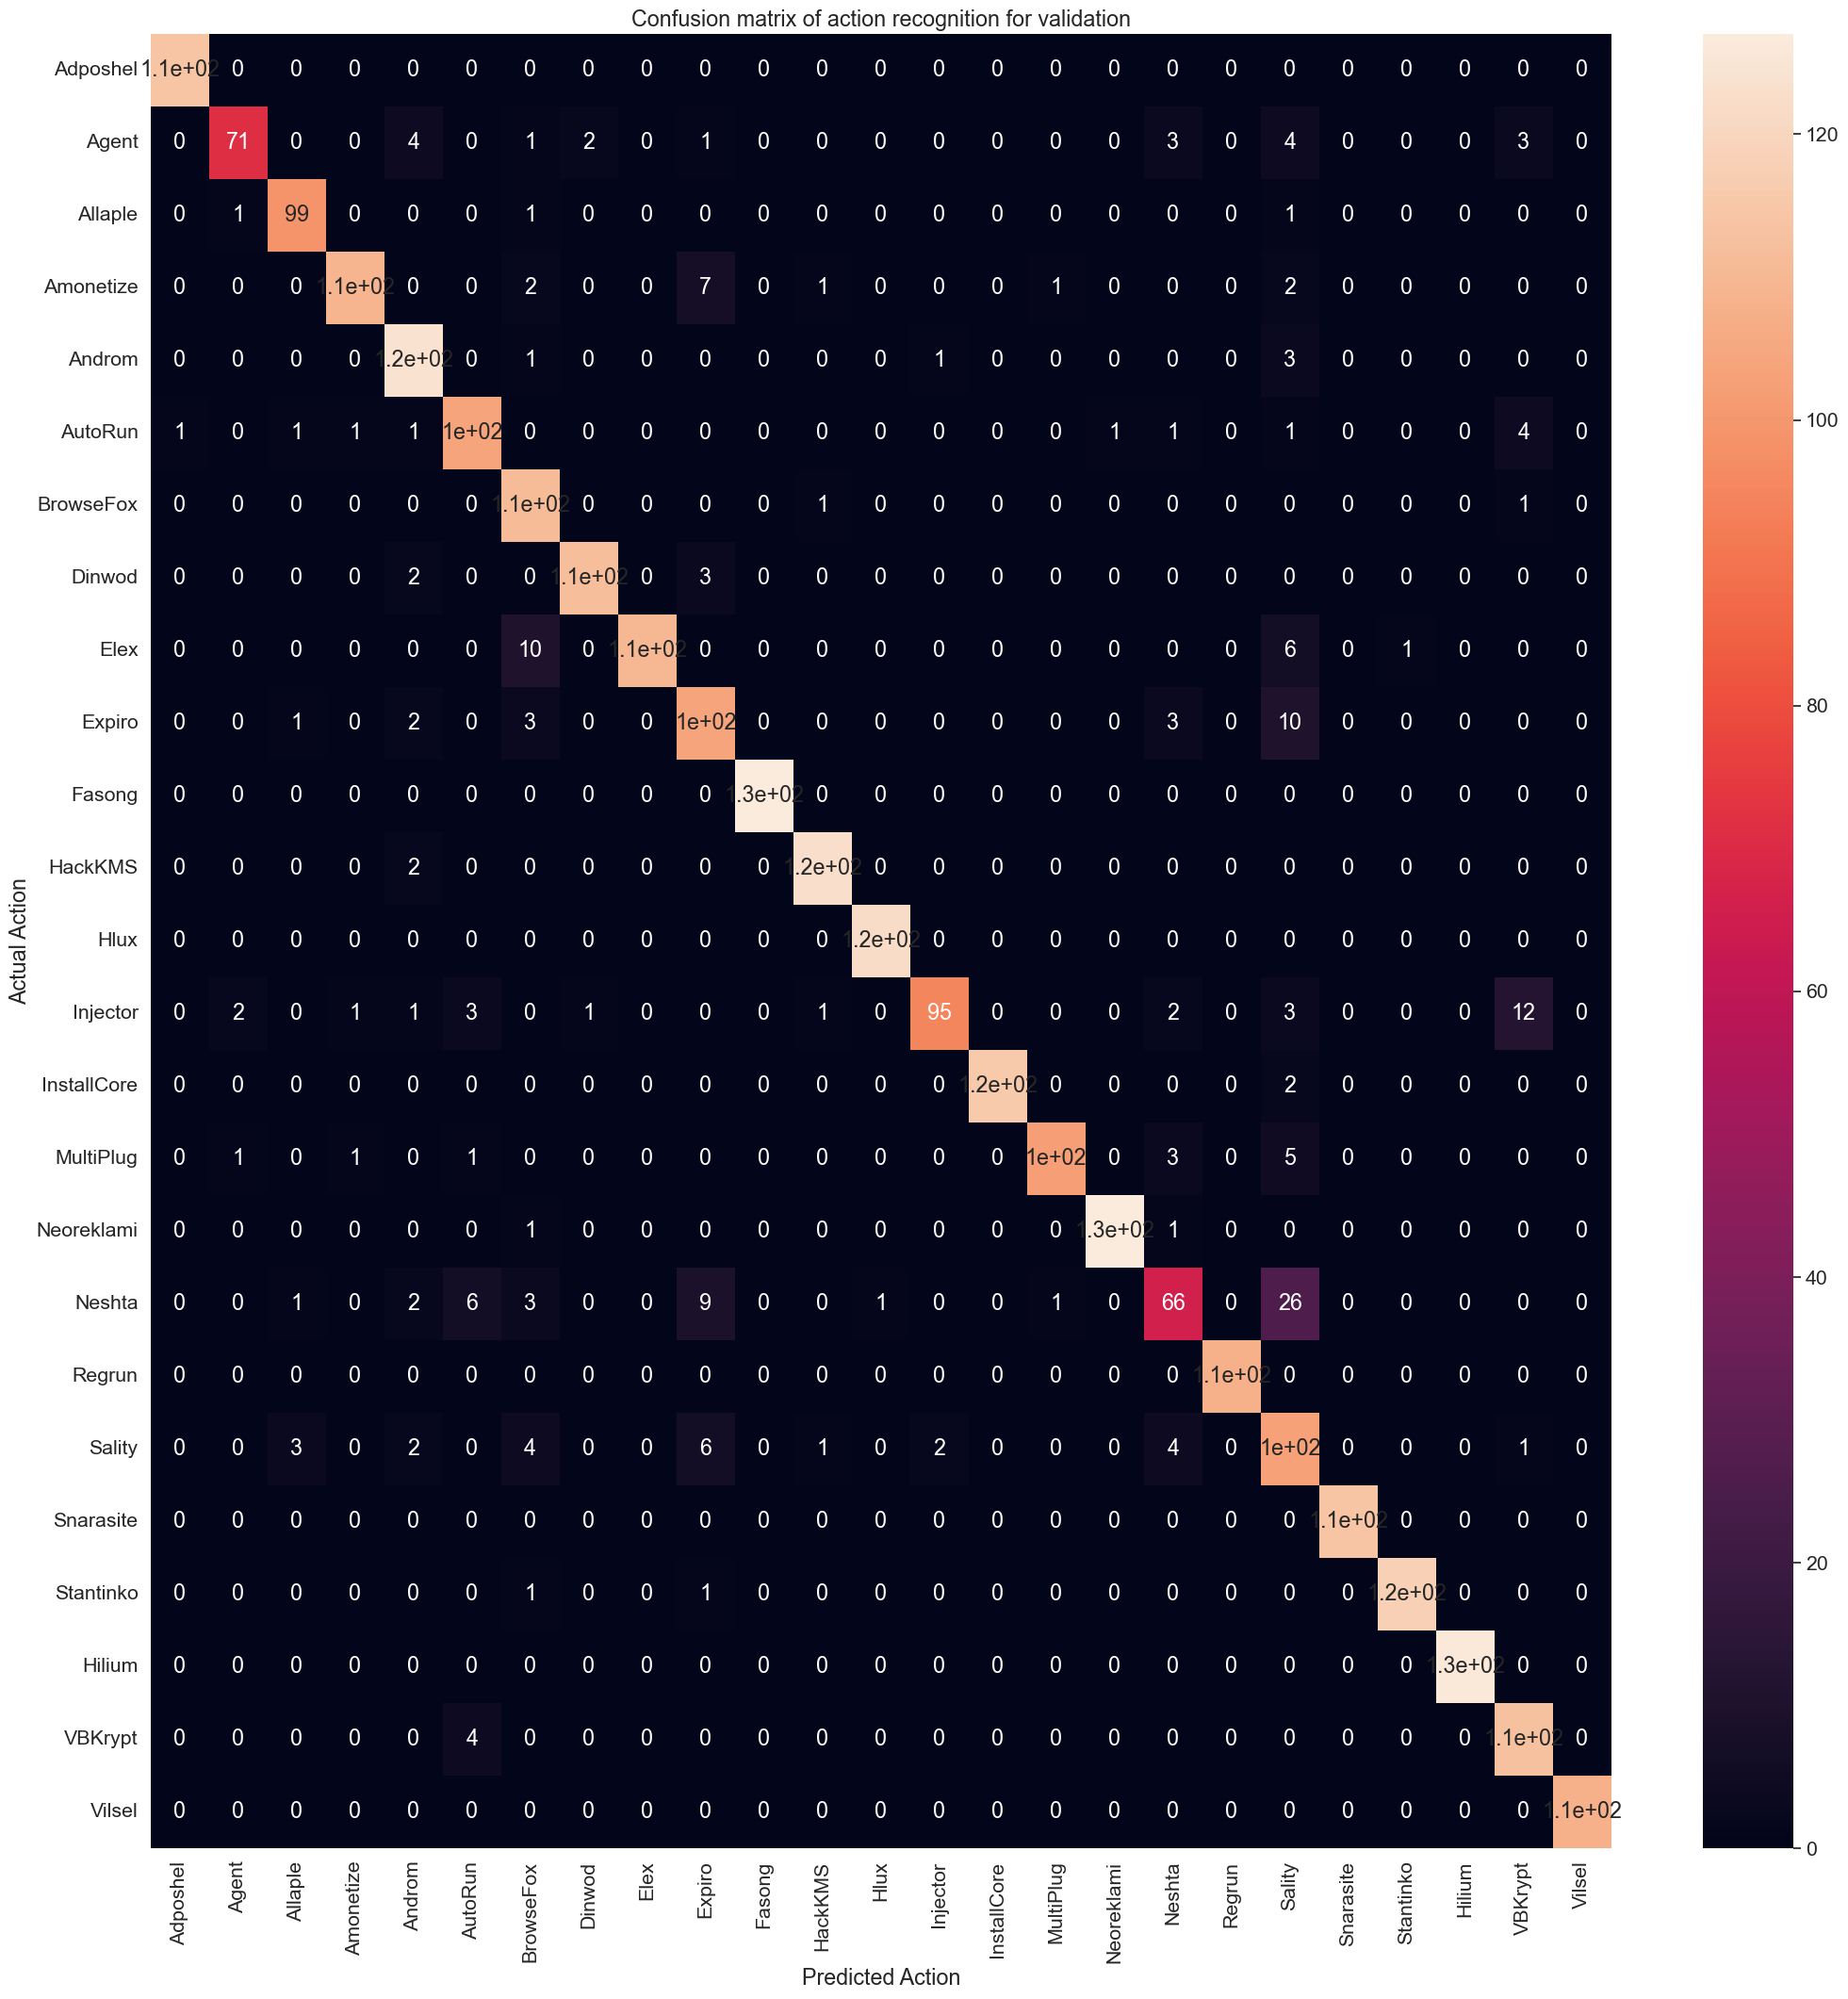

In [54]:
plot_confusion_matrix(actual, predicted, class_names, 'validation')

In [55]:
actual, predicted = get_actual_predicted_labels(ds_test)

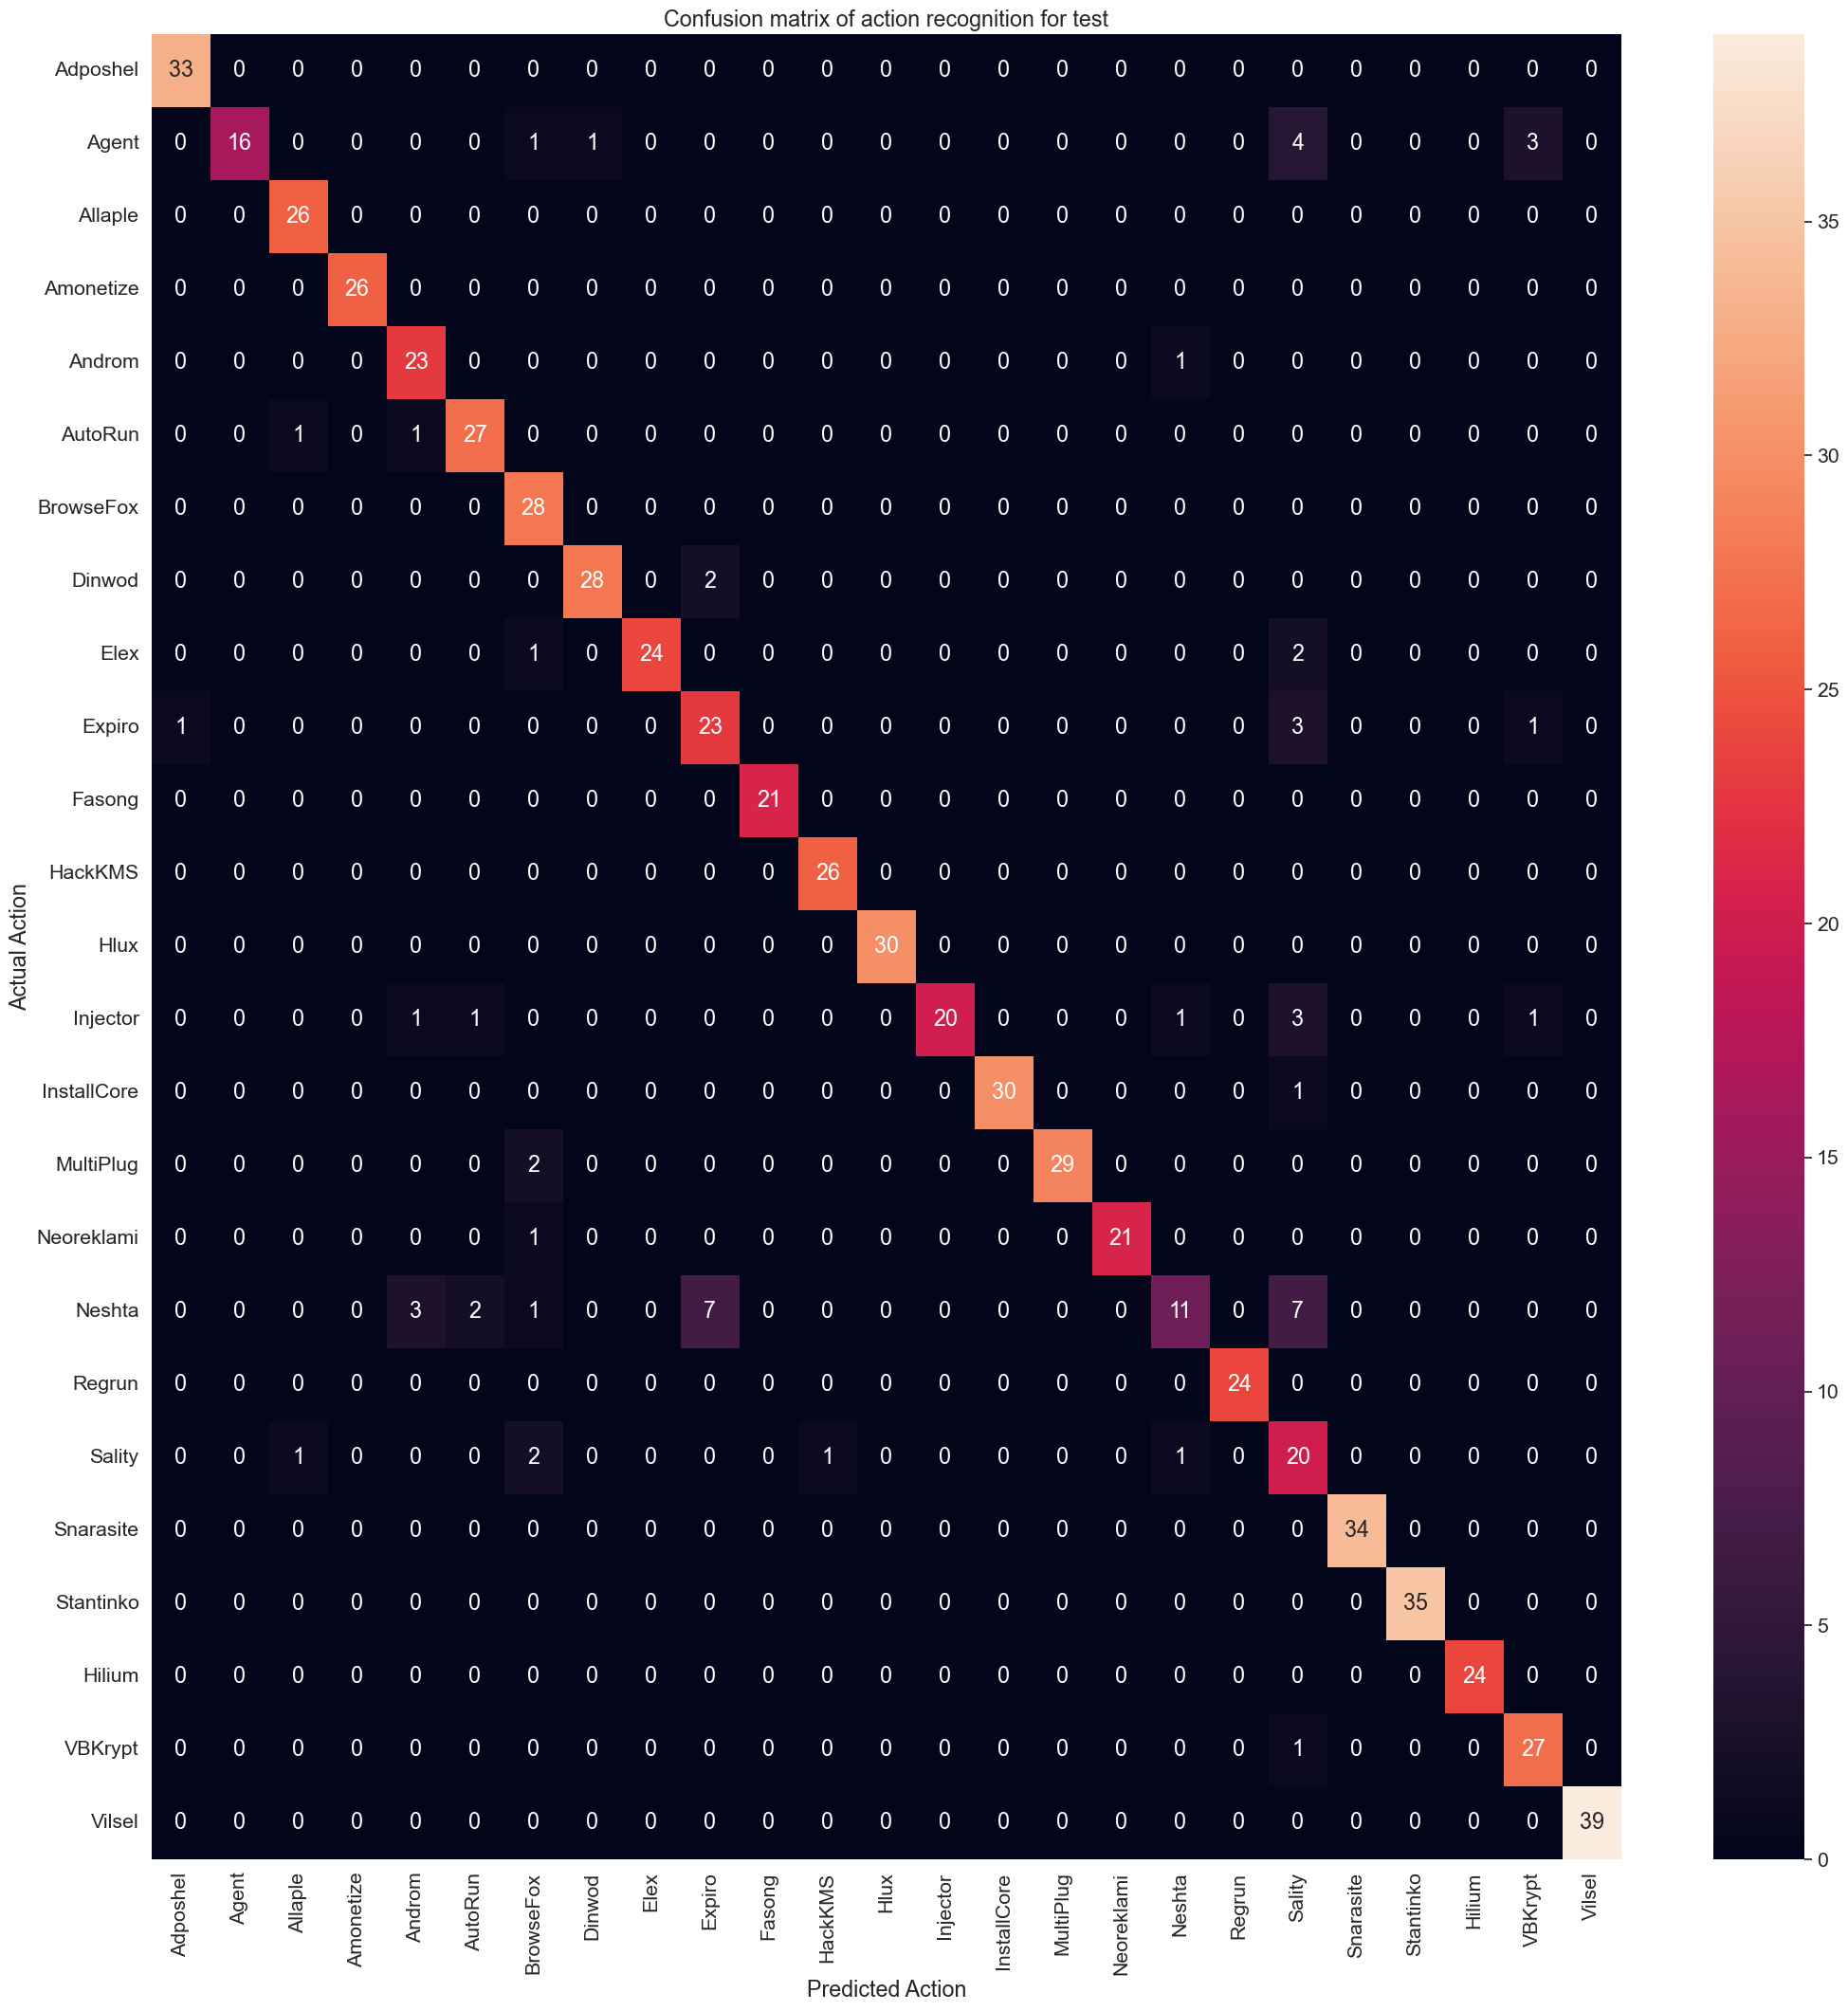

In [65]:
plot_confusion_matrix(actual, predicted, class_names, 'test')

Predictions:
 [15 22  0  4 16  8 24 24 23  4 20 17  5 10  6 19 10  0 12 16  9  5 21  7
 11 11 16  0 19  9  5 12]
Labels:
 [15 22  0  4 16  8 24 24 23 13 20 17  5 10  6 17 10  0 12 16  9  5 21  7
 11 11 16  0  9  9  5 12]


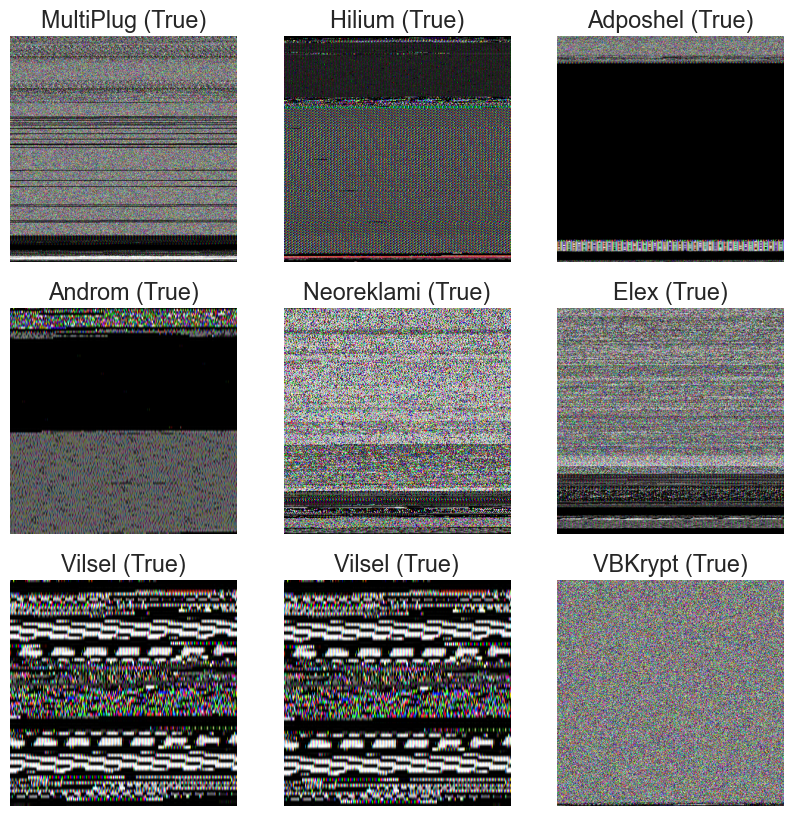

In [66]:
image_batch, label_batch = ds_val.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = np.argmax(predictions, axis=1)
label_batch = np.argmax(label_batch, axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"{class_names[predictions[i]]} ({predictions[i] == label_batch[i]})")
  plt.axis("off")

In [67]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [68]:
precision, recall = calculate_classification_metrics(actual, predicted, class_names)

In [69]:
precision

{'Adposhel': 0.9705882352941176,
 'Agent': 1.0,
 'Allaple': 0.9285714285714286,
 'Amonetize': 1.0,
 'Androm': 0.8214285714285714,
 'AutoRun': 0.9,
 'BrowseFox': 0.7777777777777778,
 'Dinwod': 0.9655172413793104,
 'Elex': 1.0,
 'Expiro': 0.71875,
 'Fasong': 1.0,
 'HackKMS': 0.9629629629629629,
 'Hlux': 1.0,
 'Injector': 1.0,
 'InstallCore': 1.0,
 'MultiPlug': 1.0,
 'Neoreklami': 1.0,
 'Neshta': 0.7857142857142857,
 'Regrun': 1.0,
 'Sality': 0.4878048780487805,
 'Snarasite': 1.0,
 'Stantinko': 1.0,
 'Hilium': 1.0,
 'VBKrypt': 0.84375,
 'Vilsel': 1.0}

In [70]:
recall

{'Adposhel': 1.0,
 'Agent': 0.64,
 'Allaple': 1.0,
 'Amonetize': 1.0,
 'Androm': 0.9583333333333334,
 'AutoRun': 0.9310344827586207,
 'BrowseFox': 1.0,
 'Dinwod': 0.9333333333333333,
 'Elex': 0.8888888888888888,
 'Expiro': 0.8214285714285714,
 'Fasong': 1.0,
 'HackKMS': 1.0,
 'Hlux': 1.0,
 'Injector': 0.7407407407407407,
 'InstallCore': 0.967741935483871,
 'MultiPlug': 0.9354838709677419,
 'Neoreklami': 0.9545454545454546,
 'Neshta': 0.3548387096774194,
 'Regrun': 1.0,
 'Sality': 0.8,
 'Snarasite': 1.0,
 'Stantinko': 1.0,
 'Hilium': 1.0,
 'VBKrypt': 0.9642857142857143,
 'Vilsel': 1.0}